In [30]:
import numpy as np
import pandas as pd
import json
import re
import MeCab
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [2]:
wiki_data = pd.read_csv("../data/wikitext_split_sentence.csv").groupby('_id')[['sentence']].sum().reset_index()
wiki_data._id = wiki_data._id.astype(str)

In [3]:
with open("../data/compound_train.json") as f:
    train = json.load(f)

In [4]:
flatten = lambda l: [item for sublist in l for item in sublist if len(item) is not 0]

In [5]:
test_df = pd.read_csv("positive_sentence.csv")

In [6]:
def is_noun(hinshi, noun):
    if not (hinshi[0] in ['名詞', '接頭詞']) and (len(noun) == 0):
        return False
    elif (hinshi[0] == '名詞') and (hinshi[1] == '固有名詞') and (hinshi[2] != '一般'):
        return False
    elif (hinshi[0] == '名詞') and (hinshi[1] in ['代名詞', '非自立', '特殊']):
        return False
    elif (hinshi[0] in ['名詞', '接頭詞']) or ((hinshi[0] == '助詞') and (hinshi[1] in ['連体化', '並立助詞', '副助詞'])):
        return True
    else:
        return False
    

def remove_tail_adv(noun, hinshi):
    while hinshi.pop() != '名詞':
        noun.pop()
        if len(hinshi) == 0:
            break
    
def get_noun_list(s):
    mecab_param = MeCab.Tagger("-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd")
    mecab_param.parse("")
    node = mecab_param.parseToNode(s)
    
    noun_list = []
    hinshi_list = []
    noun = []
    while node:
        if len(node.surface) == 0:
            node = node.next
            continue

        hinshi = node.feature.split(',')
        if is_noun(hinshi, noun):
            hinshi_list.append(hinshi[0])
            noun.append(node.surface)
        elif len(noun) > 0:
            remove_tail_adv(noun, hinshi_list)
            if len(noun) == 0:
                node = node.next
                continue
            
            noun_list.append(''.join(noun))
            hinshi_list = []
            noun = []
        
        node = node.next
    
    if len(noun) > 0:
        remove_tail_adv(noun, hinshi_list)
        noun_list.append(''.join(noun))
    
    return noun_list

In [21]:
def noun_TFIDF(entry_id, use_noun):
    mecab_param = MeCab.Tagger("-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd")
    mecab_param.parse("")
    node = mecab_param.parseToNode(use_noun)
    
    noun = []
    while node:
        if len(node.surface) == 0:
            node = node.next
            continue

        hinshi = node.feature.split(',')
        if hinshi[0] == "名詞":
            noun.append(node.surface)
        
        node = node.next
    
    
    return TFIDF(entry_id, noun)

def TFIDF(entry_id, noun):
    lower_noun = [n.lower() for n in noun]
    noun_list = list(set(tfidf_df.columns) & set(lower_noun))
    if len(noun_list) == 0:
        return 0
        
    return tfidf_df.loc[tfidf_df._id == str(entry_id), lower_noun].values.flatten().max()

In [8]:
mecab_wakati_param = MeCab.Tagger("-Owakati -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd")
wakati_entries = wiki_data.apply(lambda x: mecab_wakati_param.parse(x.sentence).strip(), axis=1).tolist()

vectorizer = TfidfVectorizer(token_pattern='[^\s]+')
tfidf_vec = vectorizer.fit_transform(wakati_entries).toarray()
features = vectorizer.get_feature_names()

tfidf_df = pd.DataFrame(tfidf_vec, columns=features).assign(_id = wiki_data._id)

In [22]:
df = pd.DataFrame()
for _, (_id, s) in test_df.iterrows():
    use_list = get_noun_list(s)
    TFIDF_list = [noun_TFIDF(_id, use_noun) for use_noun in use_list]
    tmp_df = pd.DataFrame({"_id": _id, "use": use_list, "TFIDF": TFIDF_list})
    df = df.append(tmp_df)
df.reset_index(drop=True, inplace=True)

/usr/local/var/pyenv/versions/3.6.1/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/usr/local/var/pyenv/versions/3.6.1/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


## Precision

In [24]:
noun_list = pd.read_csv("../data/noun_list_in_category_and_title.csv").noun.values

train_character_list = flatten([entry['Attributes']['特性'] for entry in train['entry']])
train_type_list = flatten([entry['Attributes']['種類'] for entry in train['entry']])
compound_list = pd.read_csv("../data/compound_list.csv")['compound'].tolist()

use_df = df[df.use.str.contains('|'.join(noun_list))]
use_df = use_df[~use_df.use.str.match('|'.join(train_character_list + train_type_list + compound_list).replace('(', '\(').replace(')', '\)'))]
use_df['_id'] = use_df._id.astype(str)

train_use_dict = \
dict(zip(
    [str(entry['WikipediaID']) for entry in train['entry']]
    , [entry['Attributes']['用途'] for entry in train['entry']]
))

In [25]:
is_contain_list1 = []
is_contain_list2 = []
predict_df = pd.DataFrame()
for _id, group in use_df.groupby('_id'):
    if not train_use_dict.get(_id):
        continue
    
    group = group[~group.duplicated('use')]
    true_use_list = train_use_dict[_id]
    
    # contains extraction data in train data
    use_str = ','.join(true_use_list)
    result1 = group.apply(lambda x: True if re.search(x.use, use_str) else False, axis=1).tolist()
    is_contain_list1 += result1   

    # contains train data in extraction data
    r2 = '|'.join(true_use_list).replace('(', '\(').replace(')', '\)')
    result2 = group.use.str.contains(r2).tolist()
    is_contain_list2 += result2
    
    predict_df = predict_df.append(group.assign(label = np.array(result1) + np.array(result2)))

is_contain_list1 = np.array(is_contain_list1)
is_contain_list2 = np.array(is_contain_list2)

print(sum(is_contain_list1) / len(is_contain_list1))
print(sum(is_contain_list2) / len(is_contain_list2))
print(sum(is_contain_list1 + is_contain_list2) / len(is_contain_list1))

0.5549618320610687
0.4549618320610687
0.6916030534351145


In [26]:
predict_df.to_csv('extracted_use_list_in_train_data.csv', index=False)
predict_df[predict_df.label == False].to_csv('extracted_use_list_in_train_data_only_false.csv', index=False)

label
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: TFIDF, dtype: object

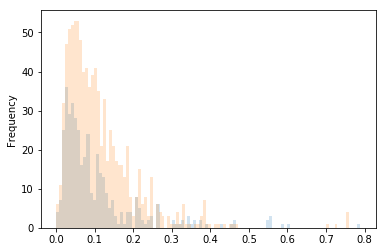

In [39]:
predict_df.groupby('label')['TFIDF'].plot(kind='hist', alpha=0.2, bins=100)